In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
!pip install opendatasets
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: uthkarshjaiswal6969
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:38<00:00, 28.8MB/s]


In [ ]:
BASE_DIR = '/content/flickr8k'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 22s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
WORKING_DIR = '/content/working_dir'

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
! gdown --id 1NPhPiyLB9dilV5AnhaiGezA9zupI6T3v

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1NPhPiyLB9dilV5AnhaiGezA9zupI6T3v
From (redirected): https://drive.google.com/uc?id=1NPhPiyLB9dilV5AnhaiGezA9zupI6T3v&confirm=t&uuid=0b9dffb0-64cd-4d48-842b-4eec7b1f5b68
To: /content/features.pkl
100% 133M/133M [00:02<00:00, 50.4MB/s]


In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:

def clean(mapping):

    for key, captions in mapping.items():

        for i in range(len(captions)):

            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
len(mapping)

8091

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length


35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

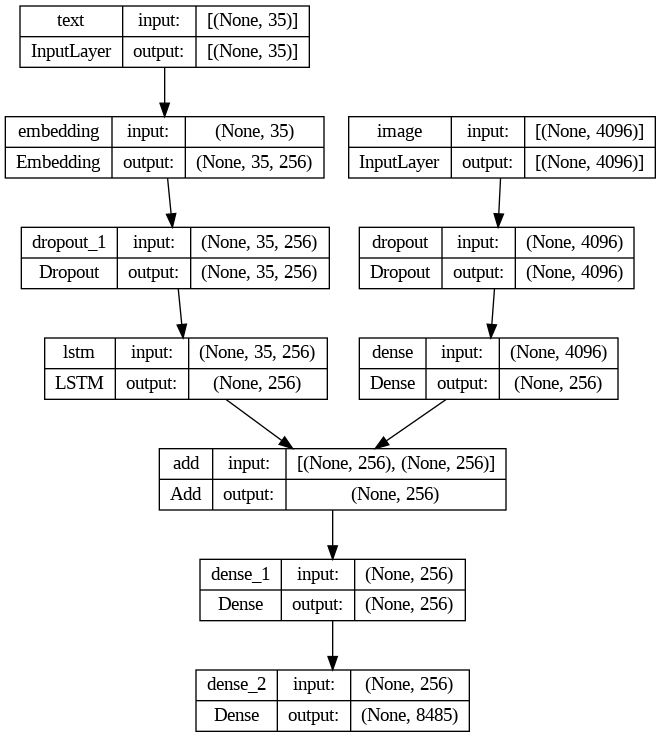

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
import matplotlib.pyplot as plt

# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

# List to store loss values
loss_values = []

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # Store the loss value
    loss_values.append(history.history['loss'][0])

# Plot the loss values
plt.plot(range(1, epochs + 1), loss_values, 'bo-', label='Training loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
! gdown --id 1iBbv5x-cSQThRbYum1cBZh2BbGYzuvjW

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iBbv5x-cSQThRbYum1cBZh2BbGYzuvjW
To: /content/best_model.h5
100% 72.0M/72.0M [00:01<00:00, 69.3MB/s]


In [ ]:
model.load_weights(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
           return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5284
BLEU-2: 0.3014
Average BLEU score: 0.4149


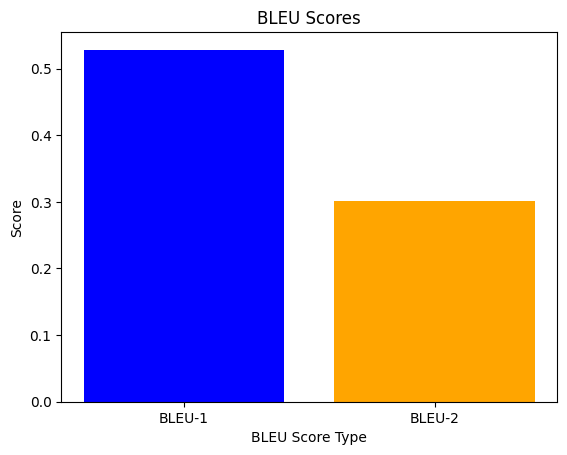

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import matplotlib.pyplot as plt

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU scores
bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")

# Calculate average BLEU score
average_bleu = np.mean([bleu_1, bleu_2])
print(f"Average BLEU score: {average_bleu:.4f}")

# Plot BLEU scores
bleu_scores = [bleu_1, bleu_2]
labels = ['BLEU-1', 'BLEU-2']

plt.bar(labels, bleu_scores, color=['blue', 'orange'])
plt.title('BLEU Scores')
plt.xlabel('BLEU Score Type')
plt.ylabel('Score')
plt.show()


In [ ]:
import os
!pip install gtts
from gtts import gTTS
from IPython.display import Audio
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]

    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Convert predicted caption to speech and save as .wav file
    tts = gTTS(y_pred)
    tts.save('predicted_caption.wav')

    # Display image
    plt.imshow(image)

    # Load and play the audio file
    sound_file = 'predicted_caption.wav'
    return Audio(sound_file, autoplay=True)

---------------------Actual---------------------
startseq bearded man in white shirt and black shorts is hiking on woodland path endseq
startseq man in white shirt is standing on trail in the woods endseq
startseq man wearing water pack and shorts on an outdoor trail endseq
startseq short stubby man with backpack is standing in forest endseq
startseq "this man wearing white t-shirt and black shorts is standing on path in the forest ." endseq
--------------------Predicted--------------------
startseq woman in black shirt and blue shorts is walking in the woods endseq


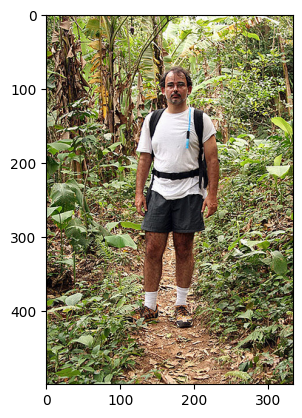

In [ ]:
generate_caption("241031254_0c6f30e3d1.jpg")

---------------------Actual---------------------
startseq brown dog running endseq
startseq brown dog running over grass endseq
startseq brown dog with its front paws off the ground on grassy surface near red and purple flowers endseq
startseq dog runs across grassy lawn near some flowers endseq
startseq yellow dog is playing in grassy area near flowers endseq
--------------------Predicted--------------------
startseq dog running through the grass endseq


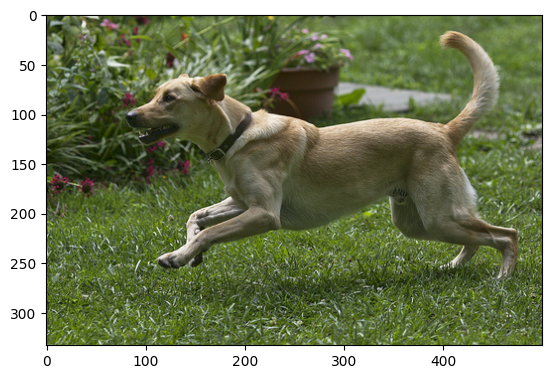

In [ ]:
generate_caption("2654514044_a70a6e2c21.jpg")

---------------------Actual---------------------
startseq dog with frisbee in front of brown dog endseq
startseq large black dog is catching frisbee while large brown dog follows shortly after endseq
startseq two dark colored dogs romp in the grass with blue frisbee endseq
startseq two dogs are catching blue frisbees in grass endseq
startseq two dogs are playing one is catching frisbee endseq
--------------------Predicted--------------------
startseq two dogs are playing in field endseq


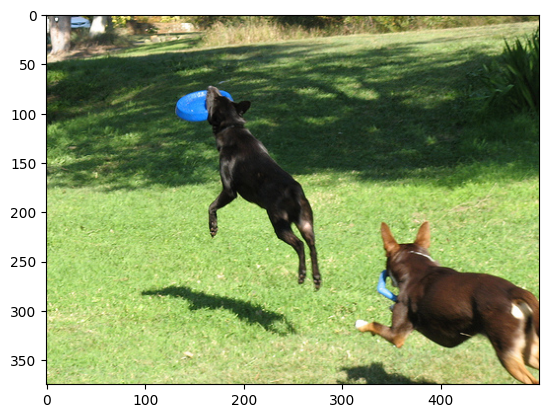

In [ ]:
generate_caption("2511019188_ca71775f2d.jpg")